Here we will create our baseline linear model. It will not contain time-dependent exogenous variables. What is more we will not focus on econometrics - BLUE assumptions!

# Classification

### Dependencies loading

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import (
    mutual_info_classif,
    f_classif,

)  # 
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.style.use("ggplot")

# np.random.seed(1916) #uncomment if you want your code to be reproducible; for the purposes of our activity, let's add some randomness to the results

### Data loading

In [12]:
import os
os.getcwd()

'd:\\finance quantitative\\Third Semester'

In [15]:
preprocessed_output_data_path = "data"

df = pd.read_csv(f"{preprocessed_output_data_path}/train_fe.csv", index_col=0)
df_test = pd.read_csv(f"{preprocessed_output_data_path}/test_fe.csv", index_col=0)

Target Variable Transformation:

Low Tax Avoidance (Class 0): ETR > 0.25 (companies paying relatively high taxes)

Medium Tax Avoidance (Class 1): 0.15 < ETR ≤ 0.25

High Tax Avoidance (Class 2): ETR ≤ 0.15 (companies with aggressive tax optimization)

In [16]:
conditions = [
    df["etr"] > 0.25,
    (df["etr"] >= 0.15) & (df["etr"] <= 0.25),
    df["etr"] <= 0.15,
]

labels = [0, 1, 2]
df["etr_category"] = np.select(conditions, labels)
print(df["etr_category"].value_counts())

etr_category
1    1668
0    1267
2    1058
Name: count, dtype: int64


In [18]:
df_test["etr_category"] = np.select(conditions, labels)
print(df_test["etr_category"].value_counts())

etr_category
1    195
0    103
2     65
Name: count, dtype: int64


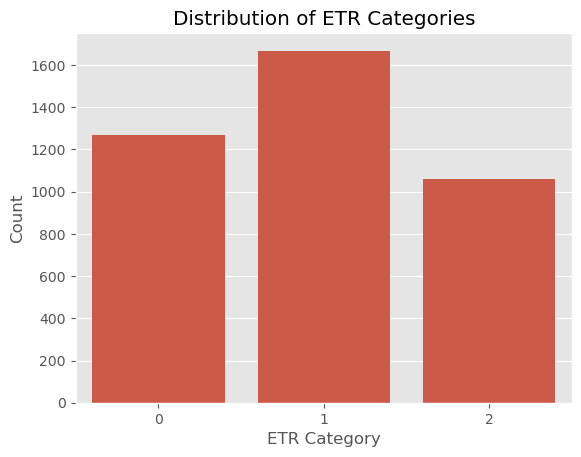

In [19]:
plt.Figure(figsize=(10, 6))
sns.countplot(x="etr_category", data=df)
plt.title("Distribution of ETR Categories")
plt.xlabel("ETR Category")
plt.ylabel("Count")
plt.show()

In [20]:
x_col = df.columns.drop(["etr", "etr_category","Ticker","Nazwa2"])

In [21]:
mutul_info_dict = dict()
for col in x_col:
    mutul_info_dict[col] = mutual_info_classif(
        df[[col]],
        df["etr_category"],
    )[0]
print(mutul_info_dict)

{'rok': 0, 'ta': 0.13613770002088987, 'txt': 0.17189627762095983, 'pi': 0.1648469491590736, 'str': 0.13411116074284424, 'xrd': 0.059546147219663004, 'ni': 0.1662938495322317, 'ppent': 0.10080982233343372, 'intant': 0.16867913200704976, 'dlc': 0.12228922975167578, 'dltt': 0.0958388065206166, 'capex': 0.1286078793953025, 'revenue': 0.13848124983854992, 'cce': 0.12274488625119817, 'adv': 0.002384054750034892, 'diff': 0.1664422646980992, 'roa': 0.13080944332621813, 'lev': 0.08834712676267142, 'intan': 0.10983468554856879, 'rd': 0.04929763857258451, 'ppe': 0.10313529451901982, 'sale': 0.10428856063851266, 'cash_holdings': 0.08630100298970556, 'adv_expenditure': 0, 'capex2': 0.08509224434724971, 'cfc': 0.08505855621975567, 'dta': 0.04771866847874007, 'capex2_scaled': 0.09417036745052476, 'y_v2x_polyarchy': 0.07705254665347838, 'y_e_p_polity': 0.029086067476211896, 'y_BR_Democracy': 0, 'WB_GDPgrowth': 0.11091653071327667, 'WB_GDPpc': 0.10806835027013428, 'WB_Inflation': 0.11210544533561717, '

In [22]:
fr = pd.DataFrame.from_dict(mutul_info_dict, orient="index", columns=["mutual_info"])
fr  #larger value means more important feature

,mutual_info
rok,0.000000
ta,0.136138
txt,0.171896
pi,0.164847
str,0.134111
...,...
lev_past,0.109244
intan_past,0.122461
ppe_past,0.134335
sale_past,0.118478


Train and evaluate THREE classification models:

Logistic Regression (multiclass)

K-Nearest Neighbors Classifier

Support Vector Classifier (SVC)

# 1. Logitic Regression multiclass
I want to compare the top 10, top 20, top 30... top all features, selcect how many features can be the optimal model

In [23]:

for i in np.arange(10, len(x_col)+1, 10):
    print(f"Top {i} features:", fr.sort_values(by="mutual_info", ascending=False).head(i).index.tolist())

Top 10 features: ['etr_y_past', 'etr_y_ma', 'diff_ma', 'txt', 'intant', 'intan_ma', 'diff', 'ni', 'pi', 'intant_sqrt']
Top 20 features: ['etr_y_past', 'etr_y_ma', 'diff_ma', 'txt', 'intant', 'intan_ma', 'diff', 'ni', 'pi', 'intant_sqrt', 'sale_ma', 'ppe_ma', 'cash_holdings_ma', 'revenue', 'ta', 'ta_log', 'ppe_past', 'str', 'roa_clip', 'roa']
Top 30 features: ['etr_y_past', 'etr_y_ma', 'diff_ma', 'txt', 'intant', 'intan_ma', 'diff', 'ni', 'pi', 'intant_sqrt', 'sale_ma', 'ppe_ma', 'cash_holdings_ma', 'revenue', 'ta', 'ta_log', 'ppe_past', 'str', 'roa_clip', 'roa', 'capex', 'cash_holdings_past', 'roa_past', 'lev_ma', 'roa_ma', 'cce', 'intan_past', 'dlc', 'sale_past', 'WB_Inflation']
Top 40 features: ['etr_y_past', 'etr_y_ma', 'diff_ma', 'txt', 'intant', 'intan_ma', 'diff', 'ni', 'pi', 'intant_sqrt', 'sale_ma', 'ppe_ma', 'cash_holdings_ma', 'revenue', 'ta', 'ta_log', 'ppe_past', 'str', 'roa_clip', 'roa', 'capex', 'cash_holdings_past', 'roa_past', 'lev_ma', 'roa_ma', 'cce', 'intan_past', 'd

In [24]:
import warnings
warnings.filterwarnings("ignore")
log_classifier = LogisticRegression(max_iter=1000)
parameter_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs',"sage"],
    'multi_class': ['ovr','multinomial'],
}

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Suppose you want 5 splits
tscv = TimeSeriesSplit(n_splits=5)

results = dict()
for i in np.arange(10, len(x_col)+1, 10):
    print(f"Training model with top {i} features...")
    clf = GridSearchCV(
        log_classifier,
        parameter_grid,
        cv=tscv,
        n_jobs=-1,
        scoring="accuracy",
    )
    selected_features = fr.sort_values(by="mutual_info", ascending=False).head(i).index.tolist()
    model = clf.fit(df[selected_features], df["etr_category"])
    results[i] = {
        "model": model,
        "best_params": clf.best_params_,
        "best_score": clf.best_score_
    }
    
    print(f"Best parameters for top {i} features: {clf.best_params_}")
    print(f"Best cross-validation score for top {i} features: {clf.best_score_}")

Training model with top 10 features...
Best parameters for top 10 features: {'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score for top 10 features: 0.5930827067669173
Training model with top 20 features...
Best parameters for top 20 features: {'C': 1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score for top 20 features: 0.4893233082706767
Training model with top 30 features...
Best parameters for top 30 features: {'C': 1, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score for top 30 features: 0.49744360902255635
Training model with top 40 features...
Best parameters for top 40 features: {'C': 1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score for top 40 features: 0.5028571428571429
Training model with top 50 features...
Best parameters for top 50 features: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
B

In [25]:
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

,model,best_params,best_score
10,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2...",0.593083
20,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'...",0.489323
30,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","{'C': 1, 'multi_class': 'multinomial', 'penalt...",0.497444
40,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'...",0.502857
50,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","{'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l...",0.501353
60,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","{'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l...",0.494737
70,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'...",0.500451
80,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2...",0.519398
90,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'...",0.519098
100,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'...",0.514286


### Therefore, we can see that the top 10 features can give better scrore, then test to find whether align with training

In [26]:
Test_classification_reports = {}
for i in np.arange(10, len(x_col)+1, 10):
    selected_features = fr.sort_values(by="mutual_info", ascending=False).head(i).index.tolist()
    params = results_df.loc[i, "best_params"]
    
    model = LogisticRegression(**params, max_iter=1000).fit(df[selected_features], df["etr_category"])
    pred = model.predict(df_test[selected_features])
    
    report_dict = classification_report(df_test["etr_category"], pred, output_dict=True)
    report_df = pd.DataFrame.from_dict(report_dict["macro avg"], orient="index").transpose()
    Test_classification_reports[i] = report_df

In [27]:
pd.concat(Test_classification_reports, names=['num_features'])

,,precision,recall,f1-score,support
num_features,,,,,
10,0,0.554321,0.538495,0.543291,363.0
20,0,0.356926,0.426587,0.387812,363.0
30,0,0.579763,0.448345,0.381323,363.0
40,0,0.347222,0.424944,0.380921,363.0
50,0,0.501925,0.419998,0.386013,363.0
60,0,0.425400,0.409924,0.377201,363.0
70,0,0.371743,0.403269,0.367594,363.0
80,0,0.420170,0.424147,0.394670,363.0
90,0,0.426722,0.432329,0.401942,363.0


#### Still, the optimal model is 10 features, Now the baseline model with Macro F1 0.543, not quite good

# 2. KNN classifer
Due to KNN is more time consuming, and KNN may have the high-dimension issues. So just try 10, 20,30 feautures, and also the continuous features should do the standardsclaer

In [30]:
top_10_features = fr.sort_values(by="mutual_info", ascending=False).head(10).index.tolist()
top_20_features = fr.sort_values(by="mutual_info", ascending=False).head(20).index.tolist()
top_30_features = fr.sort_values(by="mutual_info", ascending=False).head(30).index.tolist()

In [31]:
df[top_30_features].info() #all float
scale_top10 = StandardScaler().fit(df[top_10_features])
scale_top20 = StandardScaler().fit(df[top_20_features])
scale_top30 = StandardScaler().fit(df[top_30_features])
X_train_top10 = scale_top10.transform(df[top_10_features])
X_train_top20 = scale_top20.transform(df[top_20_features])
X_train_top30 = scale_top30.transform(df[top_30_features])

<class 'pandas.core.frame.DataFrame'>
Index: 3993 entries, 0 to 4354
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   etr_y_past          3993 non-null   float64
 1   etr_y_ma            3993 non-null   float64
 2   diff_ma             3993 non-null   float64
 3   txt                 3993 non-null   float64
 4   intant              3993 non-null   float64
 5   intan_ma            3993 non-null   float64
 6   diff                3993 non-null   float64
 7   ni                  3993 non-null   float64
 8   pi                  3993 non-null   float64
 9   intant_sqrt         3993 non-null   float64
 10  sale_ma             3993 non-null   float64
 11  ppe_ma              3993 non-null   float64
 12  cash_holdings_ma    3993 non-null   float64
 13  revenue             3993 non-null   float64
 14  ta                  3993 non-null   float64
 15  ta_log              3993 non-null   float64
 16  ppe_past   

In [32]:
X_test_top10 = scale_top10.transform(df_test[top_10_features])
X_test_top20 = scale_top20.transform(df_test[top_20_features])
X_test_top30 = scale_top30.transform(df_test[top_30_features])

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder
from sklearn.compose import ColumnTransformer

# KNN pipeline
knn = KNeighborsClassifier()

parameter_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['minkowski', 'euclidean', 'manhattan']
} # 4*2*4*3=96 combinations

clf_top10 = RandomizedSearchCV(
    KNeighborsClassifier(),
    parameter_grid,
    n_iter=20,
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=1916
)

clf_top20 = RandomizedSearchCV(
    KNeighborsClassifier(),
    parameter_grid,
    n_iter=20,
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=1917  # optional: different random state
)

clf_top30 = RandomizedSearchCV(
    KNeighborsClassifier(),
    parameter_grid,
    n_iter=20,
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=1917  # optional: different random state
)

clf_top10.fit(X_train_top10, df["etr_category"])
clf_top20.fit(X_train_top20, df["etr_category"])
clf_top30.fit(X_train_top30, df["etr_category"])

print("Best parameters for top 10 features:", clf_top10.best_params_)
print("Best parameters for top 20 features:", clf_top20.best_params_)
print("Best parameters for top 30 features:", clf_top30.best_params_)

print("Best cross-validation score for top 10 features:", clf_top10.best_score_)
print("Best cross-validation score for top 20 features:", clf_top20.best_score_)
print("Best cross-validation score for top 30 features:", clf_top30.best_score_)


Best parameters for top 10 features: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
Best parameters for top 20 features: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'minkowski', 'algorithm': 'ball_tree'}
Best parameters for top 30 features: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'euclidean', 'algorithm': 'auto'}
Best cross-validation score for top 10 features: 0.6266246497827614
Best cross-validation score for top 20 features: 0.5646900644604316
Best cross-validation score for top 30 features: 0.5444658645321276


### KNN has an significant imporement with 0.627 score,  and the still top 10 features has the best scores, then test

In [34]:
knn_top10 = KNeighborsClassifier(**clf_top10.best_params_).fit(X_train_top10, df["etr_category"])
knn_top20 = KNeighborsClassifier(**clf_top20.best_params_).fit(X_train_top20, df["etr_category"])
knn_top30 = KNeighborsClassifier(**clf_top30.best_params_).fit(X_train_top30, df["etr_category"])

knn_top10_predict = knn_top10.predict(X_test_top10)
knn_top20_predict = knn_top20.predict(X_test_top20)
knn_top30_predict = knn_top30.predict(X_test_top30)

print("KNN Top 10 Features Classification Report:\n", classification_report(df_test["etr_category"], knn_top10_predict))
print("KNN Top 20 Features Classification Report:\n", classification_report(df_test["etr_category"], knn_top20_predict))
print("KNN Top 30 Features Classification Report:\n", classification_report(df_test["etr_category"], knn_top30_predict))

KNN Top 10 Features Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.62      0.59       103
           1       0.72      0.64      0.67       195
           2       0.45      0.54      0.49        65

    accuracy                           0.61       363
   macro avg       0.58      0.60      0.59       363
weighted avg       0.63      0.61      0.62       363

KNN Top 20 Features Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.57      0.59       103
           1       0.72      0.64      0.68       195
           2       0.37      0.52      0.44        65

    accuracy                           0.60       363
   macro avg       0.56      0.58      0.57       363
weighted avg       0.62      0.60      0.61       363

KNN Top 30 Features Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.59      0.60       1

#### Therefore, KNN has the optimal macro F1 WITH 0.59, with top10 features

# 3. Vector support machine learning

In [38]:
parameter_grid = {
    'C': [0.1, 1, 10],                 
    'kernel': ['linear', 'rbf'],       
    'gamma': ['scale', 0.1, 1],        
}

tscv = TimeSeriesSplit(n_splits=3)

clf_top10 = GridSearchCV(
    SVC(),
    parameter_grid,
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
)
clf_top20 = GridSearchCV(
    SVC(),
    parameter_grid,
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
)
clf_top30 = GridSearchCV(
    SVC(),
    parameter_grid,
    cv=tscv,
    scoring='f1_macro',
    n_jobs=-1,
)

clf_top10.fit(X_train_top10, df["etr_category"])
clf_top20.fit(X_train_top20, df["etr_category"])
clf_top30.fit(X_train_top30, df["etr_category"])

print("Best parameters for top 10 features:", clf_top10.best_params_)
print("Best parameters for top 20 features:", clf_top20.best_params_) 
print("Best parameters for top 30 features:", clf_top30.best_params_)    

print("Best cross-validation score for top 10 features:", clf_top10.best_score_)
print("Best cross-validation score for top 20 features:", clf_top20.best_score_)
print("Best cross-validation score for top 30 features:", clf_top30.best_score_)



Best parameters for top 10 features: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best parameters for top 20 features: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for top 30 features: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score for top 10 features: 0.6343828228275804
Best cross-validation score for top 20 features: 0.6145099409290814
Best cross-validation score for top 30 features: 0.6074770162322892


In [39]:
SVC_top10 = SVC(**clf_top10.best_params_).fit(X_train_top10, df["etr_category"])
SVC_top20 = SVC(**clf_top20.best_params_).fit(X_train_top20, df["etr_category"])
SVC_top30 = SVC(**clf_top30.best_params_).fit(X_train_top30, df["etr_category"])

SVC_top10_predict = SVC_top10.predict(X_test_top10)
SVC_top20_predict = SVC_top20.predict(X_test_top20)
SVC_top30_predict = SVC_top30.predict(X_test_top30)

print("SVC Top 10 Features Classification Report:\n", classification_report(df_test["etr_category"], SVC_top10_predict))
print("SVC Top 20 Features Classification Report:\n", classification_report(df_test["etr_category"], SVC_top20_predict))
print("SVC Top 30 Features Classification Report:\n", classification_report(df_test["etr_category"], SVC_top30_predict))

SVC Top 10 Features Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61       103
           1       0.74      0.69      0.71       195
           2       0.44      0.54      0.49        65

    accuracy                           0.64       363
   macro avg       0.60      0.61      0.60       363
weighted avg       0.65      0.64      0.64       363

SVC Top 20 Features Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.62      0.61       103
           1       0.75      0.72      0.73       195
           2       0.49      0.52      0.51        65

    accuracy                           0.66       363
   macro avg       0.61      0.62      0.62       363
weighted avg       0.66      0.66      0.66       363

SVC Top 30 Features Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.61      0.60       1

#### Therefore, SVC has the optimal macro F1 WITH 0.62 in these 3 models（LM, KNN, SVC）with top 20 features

In [40]:
import pickle
import os

# Create a directory for models if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save best  SVC model for top 20 features
with open("models/SVC_top20.pkl", "wb") as f:
    pickle.dump(clf_top20.best_estimator_, f)

print("✅ Models saved successfully in 'models/' directory!")

✅ Models saved successfully in 'models/' directory!


#### Therefore, when comparing different feature selection methods for relatively small datasets, feature selection plays a crucial role. Using too many features can easily lead to overfitting, especially in distance-based models or basic Linear Regression. Across the three models tested, the best performance was achieved when using around 10–20 top features, rather than including all 100+ features. This suggests that focusing on the most informative variables improves model accuracy and generalization.

#### However, I wonder if this issue might be reduced when using decision tree–based algorithms. Models like Random Forest and XGBoost inherently include mechanisms such as feature subsampling and regularization that help control variance and prevent overfitting. Therefore, in these models, including a larger number of features might actually lead to better performance. Therefore, after this semester's learning, I'll try these models again in this prediction.